In [1]:
# https://www.cs.yale.edu/homes/el327/datamining2013aFiles/07_singular_value_decomposition.pdf

In [12]:
import numpy as np
from numba import jit

from typing import TYPE_CHECKING, Tuple

if TYPE_CHECKING:
    import numpy.typing as npt

@jit(nopython=True, parallel=True, fastmath=True)
def power_method(
    A: "npt.NDArray[np.float64]", iterations: int
) -> Tuple["npt.NDArray[np.float64]", "np.float64", "npt.NDArray[np.float64]"]:
    
    n, p = A.shape

    # Pick random vector to initialize the sequence
    # Using uniform distribution instead of normal
    # So that the code can be numba-jit compatible
    v = np.random.random(size=p)
    
    # Precompute transformation
    C = A.T.dot(A)
    
    for i in range(iterations):
        v = C.dot(v)

    v /= np.linalg.norm(v)
    u = A.dot(v)
    s = np.linalg.norm(u)
    u /= s

    return u, s, v

@jit(nopython=True, parallel=True, fastmath=True)
def svd(
    A: "npt.NDArray[np.float64]",
    delta: float = 0.001,
    epsilon: float = 0.97,
    _lambda: float = 2
) -> Tuple["npt.NDArray[np.float64]", "npt.NDArray[np.float64]", "npt.NDArray[np.float64]"]:
    
    n, p = A.shape
    max_rank = min(n, p)
    U = np.zeros((n, n))
    S = np.zeros((n, p))
    V = np.zeros((p, p))
    
    # Iterations for computing the power-method
    iterations = int(np.log(4 * np.log(2 * p / delta) / (epsilon * delta)) / (2 * _lambda))
    
    # Only loop up to the maximum possible rank
    for i in range(max_rank):
        u, s, v = power_method(A, iterations)
        A -= s * np.outer(u, v)
        U[i], S[i, i], V[i] = u, s, v
    
    # Need to return U.T since we are storing the computed columns 
    # row-wise for efficiency
    return U.T, S, V

In [13]:
def _test_power_method(A: np.ndarray):
    
    n, p = A.shape
    delta = 0.001
    epsilon = 0.97
    _lambda = 2

    iterations = int(np.log(4 * np.log(2 * p / delta) / (epsilon * delta)) / (2 * _lambda))
    
    print("A:", A)
    my_u, my_s, my_v = power_method(A.copy(), iterations)
    u, s, vh = np.linalg.svd(A.copy())
    print(f"U Actual: {my_u}, True: {u[0]}")
    print(f"S Actual: {my_s}, True: {s[0]}")
    print(f"V Actual: {my_v}, True: {vh[0]}")
    print("\n")

def test_power_method():
    A = np.array(([1, 2, 3], [4, 5, 6]), dtype=np.float64)
    _test_power_method(A)
    
    A = np.array(([1, 2], [4, 5]), dtype=np.float64)
    _test_power_method(A)
    
def _test_svd(A: np.ndarray):
    print("A:", A)
    my_u, my_s, my_v = svd(A.copy())
    u, s, vh = np.linalg.svd(A.copy())
    print(f"U Actual: {my_u} \nTrue: {u}\n")
    print(f"S Actual: {my_s} \nTrue: {s}\n")
    print(f"V Actual: {my_v} \nTrue: {vh}\n")
    print("Recon:", my_u @ my_s @ my_v)
    print("\n")
    
def test_svd():
    A = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float64)
    _test_svd(A)
    
    A = np.array([[1, 2], [4, 5]], dtype=np.float64)
    _test_svd(A)
    
    A = np.array([[1, 2], [3, 4], [5, 6]], dtype=np.float64)
    _test_svd(A)
    
test_power_method()
test_svd()

A: [[1. 2. 3.]
 [4. 5. 6.]]
U Actual: [0.3863176  0.92236582], True: [-0.3863177  -0.92236578]
S Actual: 9.508032000687344, True: 9.508032000695724
V Actual: [0.42866821 0.56630707 0.70394593], True: [-0.42866713 -0.56630692 -0.7039467 ]


A: [[1. 2.]
 [4. 5.]]
U Actual: [0.32453666 0.94587312], True: [-0.32453643 -0.9458732 ]
S Actual: 6.767828935585953, True: 6.767828935632369
V Actual: [0.60699071 0.79470893], True: [-0.60699365 -0.79470668]


A: [[1. 2. 3.]
 [4. 5. 6.]]
U Actual: [[ 0.38631799  0.92234774]
 [ 0.92236566 -0.38636078]] 
True: [[-0.3863177  -0.92236578]
 [-0.92236578  0.3863177 ]]

S Actual: [[9.508032   0.         0.        ]
 [0.         0.77286964 0.        ]] 
True: [9.508032   0.77286964]

V Actual: [[ 0.42866407  0.56630649  0.70394891]
 [-0.80596554 -0.11238456  0.58119641]
 [ 0.          0.          0.        ]] 
True: [[-0.42866713 -0.56630692 -0.7039467 ]
 [ 0.80596391  0.11238241 -0.58119908]
 [ 0.40824829 -0.81649658  0.40824829]]

Recon: [[1. 2. 3.]
 [4. 

In [16]:
import time
from tqdm import tqdm

np.random.seed(0)

my_times, np_times = [], []

n_vals = [10 ** i for i in range(1, 4)]

for n in tqdm(n_vals):
    A = np.random.normal(size=(n, n))
    B = A.copy()
    
    # Time my implementation
    start = time.time()
    svd(A)
    stop = time.time()
    my_times.append(stop - start)
    
    # Time numpy implementation
    start = time.time()
    np.linalg.svd(B)
    stop = time.time()
    np_times.append(stop - start)
    
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.52s/it]


In [6]:
import pandas as pd
# python 
df = pd.DataFrame({"My Implementation": my_times, "Numpy": np_times, "N": n_vals})
df

,My Implementation,Numpy,N
0,0.001798,0.000088,10
1,0.044261,0.004013,100
2,7.440965,0.209067,1000


In [10]:
import pandas as pd
# Without opt
df = pd.DataFrame({"My Implementation": my_times, "Numpy": np_times, "N": n_vals})
df

,My Implementation,Numpy,N
0,0.000260,0.000180,10
1,0.007542,0.003428,100
2,13.400800,0.294489,1000


In [15]:
import pandas as pd
# Without opt
df = pd.DataFrame({"My Implementation": my_times, "Numpy": np_times, "N": n_vals})
df

,My Implementation,Numpy,N
0,0.004307,0.000095,10
1,0.055683,0.002844,100
2,10.206146,0.267625,1000


<AxesSubplot:xlabel='N'>

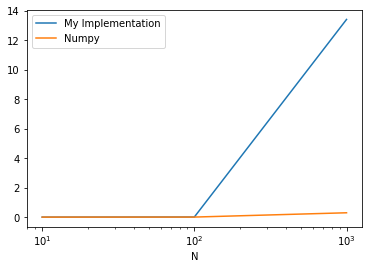

In [11]:
df.plot(x="N", logx=True)

In [18]:
28 * 3 * 10**6

84000000

In [ ]:
import time
# Size of real data
A = np.random.normal(size=(28 * 3, 10**6))
B = A.copy()

# # Time my implementation
# start = time.time()
# svd(A)
# stop = time.time()
# my_times.append(stop - start)

# Time numpy implementation
start = time.time()
np.linalg.svd(B)
stop = time.time()
np_times.append(stop - start)

In [17]:
n = 1000
A = np.random.normal(size=(n, n))
svd(A)
svd.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function svd, 
/var/folders/74/4jdnr7zn79q0h8cj7fy26vjm0000gn/T/ipykernel_13747/3642769463.py 
(34)  


Parallel loop listing for  Function svd, /var/folders/74/4jdnr7zn79q0h8cj7fy26vjm0000gn/T/ipykernel_13747/3642769463.py (34) 
---------------------------------------------------------------------------------------------------|loop #ID
@jit(nopython=True, parallel=True, fastmath=True)                                                  | 
def svd(                                                                                           | 
    A: "npt.NDArray[np.float64]",                                                                  | 
    delta: float = 0.001,                                                                          | 
    epsilon: float = 0.97,                                                                         | 
    _lambda: float = 2                                                                             | 
) -> Tuple["